 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

## Added some cleanup checks

In [2]:
df.shape

(748, 5)

In [3]:
df.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [4]:
df.isnull().sum()

months_since_last_donation     0
number_of_donations            0
total_volume_donated           0
months_since_first_donation    0
made_donation_in_march_2007    0
dtype: int64

In [5]:
df.describe()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [6]:
df.dtypes

months_since_last_donation     int64
number_of_donations            int64
total_volume_donated           int64
months_since_first_donation    int64
made_donation_in_march_2007    int64
dtype: object

In [7]:
# I'll re-cast the whole dataset as floats to prevent annoying notifications about dtype
# changes when running GridSearchCV
df = df.astype('float64')
df.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2.0,50.0,12500.0,98.0,1.0
1,0.0,13.0,3250.0,28.0,1.0
2,1.0,16.0,4000.0,35.0,1.0
3,2.0,20.0,5000.0,45.0,1.0
4,1.0,24.0,6000.0,77.0,0.0


## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
y_val = df['made_donation_in_march_2007']
majority_class = y_val.mode()[0]
y_pred = np.full(shape=df.shape[0], fill_value=majority_class)

print(accuracy_score(y_val, y_pred))

0.7620320855614974


In [9]:
# For a binary variable like this, the accuracy score just reflects the 
# distribution of that variable in y

y_val.value_counts(normalize=True)

0.0    0.762032
1.0    0.237968
Name: made_donation_in_march_2007, dtype: float64

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

In [10]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86       570
         1.0       0.00      0.00      0.00       178

   micro avg       0.76      0.76      0.76       748
   macro avg       0.38      0.50      0.43       748
weighted avg       0.58      0.76      0.66       748



/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Majority class baseline is polarizing. The recall of the positive class is zero, because by assuming that nobody donated we retrieved none of the people that did.  That is the usual meaning of recall, though we could also talk about the recall of the negative class, in which case we retrieved all of them.

In bothcases, recall means the fraction of the relevant instances that have been retrieved, over the total amount of relevant instances.

## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [11]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='made_donation_in_march_2007')
y = df['made_donation_in_march_2007']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# Verify all shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((561, 4), (187, 4), (561,), (187,))

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

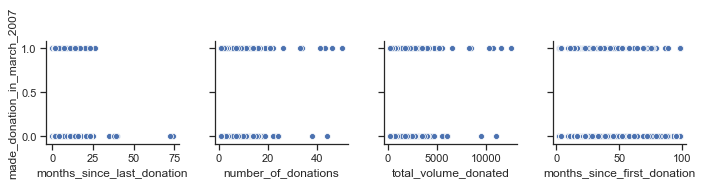

In [24]:
# In order to choose my scaler, I'll check first whether there are any stark outliers.
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
# y_vars and x_vars are lists of column names.
sns.pairplot(data=df, y_vars=['made_donation_in_march_2007'], x_vars=X.columns)
plt.show()

In [14]:
# No stark outliers, so I'll go with StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# Define an estimator and param_grid
pipe = make_pipeline(
    StandardScaler(), 
    SelectKBest(f_classif), 
    LogisticRegression(solver='lbfgs'))

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [51]:
param_grid = {
    'selectkbest__k': [1,2,3,4],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, 
                  scoring='recall', 
                  verbose=1)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    4.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x1a1c471158>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3, 4], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [52]:
gs.best_score_

0.784519402166461

In [53]:
gs.best_params_

{'logisticregression__C': 0.0001,
 'logisticregression__class_weight': 'balanced',
 'selectkbest__k': 1}

## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

In [18]:
TN = 85
FN = 8
FP = 58
TP = 36
total = 85+8+58+36
actual_yes = 8+36
actual_no = 85+58
predicted_yes = 58+36
predicted_no = 85+8

Calculate accuracy

In [19]:
accuracy = (TP+TN)/total
accuracy

0.6470588235294118

Calculate precision

In [20]:
precision = TP/predicted_yes
precision

0.3829787234042553

Calculate recall

In [21]:
recall = TP/actual_yes
recall

0.8181818181818182

## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 

### Part 1 bonus: feature engineering

In [12]:
# Based on the pairplot, it looks like high values of months_since_last_donation should
# more starkly predict that a person would not donate in March 2007.  Thus, I'll square that 
# feature and see if it improves my classification (by giving greater weight to people who 
# haven't donated in a long time).  I'll create a second dataset, df2, to contain my 
# engineered features and remain separate to DF (so I can compare the two.)

df2 = df.copy()
df2['lag_squared'] = df2.months_since_last_donation**2

X2 = df2.drop(columns='made_donation_in_march_2007')
y2 = df['made_donation_in_march_2007']

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42)

# Verify all shapes
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((561, 5), (187, 5), (561,), (187,))

### Part 2 bonus: expanded pipeline
The fact that SelectKBest chose `k=1` means that LogisticRegression performs best when it ignores all the othear features and just uses the top one.  Thus, feature engineering won't change my recall score unless my engineered feature is so good that SelectKBest changes to `k=2` to include it.  Very unlikely scenario, but let's find out.

In [54]:
# Original pipeline, fit to the new data
param_grid = {
    'selectkbest__k': [1,2,3,4],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

pipe = make_pipeline(
    StandardScaler(), 
    SelectKBest(f_classif), 
    LogisticRegression(solver='lbfgs'))

gs2 = GridSearchCV(pipe, param_grid=param_grid, cv=5, 
                  scoring='recall', 
                  verbose=1)
gs2.fit(X2_train, y2_train);
# The previous best_score was 0.784519402166461
gs2.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    4.2s finished


0.784519402166461

In [55]:
gs2.best_params_

{'logisticregression__C': 0.0001,
 'logisticregression__class_weight': 'balanced',
 'selectkbest__k': 1}

Sure enough, SelectKBest still chooses only one feature and is ignoring my engineered one.  Clearly all the other features are so useless that the model is better off ignoring them.  The only way I can improve this score, then, is if I can somehow make the best feature even better than it is right now.  Enter PCA.

In [62]:
from sklearn.decomposition import PCA
# I'm getting rid of SelectKBest, since PCA allows me to decide how many components to retain.  It achieves
# basically the same result.

param_grid2 = {
    'pca__n_components': [1,2,3,4,5],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

pipe2 = make_pipeline(
    StandardScaler(),
    PCA(),
    LogisticRegression(solver='lbfgs'))

gs2 = GridSearchCV(pipe2, param_grid=param_grid2, cv=5, 
                  scoring='recall', 
                  verbose=1)
gs2.fit(X2_train, y2_train);
# The previous best_score was 0.784519402166461
gs2.best_score_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    5.2s finished
/anaconda3/envs/sandbox/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.799876593994241

In [63]:
gs2.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__class_weight': 'balanced',
 'pca__n_components': 2}

Success!! The recall score went slightly up!

### Part 3 bonus: printouts and testing

In [50]:
# Which features were selected by the original gridsearch?
selected_mask = gs.best_estimator_.named_steps['selectkbest'].get_support()
selected_names = X_train.columns[selected_mask]
unselected_names = X_train.columns[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(f'> {name}')

print()
print('Features not selected:')
for name in unselected_names:
    print(f'> {name}')

Features selected:
> months_since_last_donation

Features not selected:
> number_of_donations
> total_volume_donated
> months_since_first_donation


### Part 1 bonus: extra scores

In [22]:
F1 = 2*precision*recall/(precision+recall)
F1

0.5217391304347826

In [23]:
FPR = FP/actual_no
FPR

0.40559440559440557